In [16]:
# mandatory xcube store imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.dsio import open_cube
from xcube.core.geom import clip_dataset_by_geometry

from xcube_cmems.store import CmemsDataStore
import xcube_cmems
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space

# Utilities for notebook visualization.
from IPython.display import JSON

import os
import numpy as np
import xarray as xr
import rioxarray
import bottleneck

import shapely
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs   
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from shapely.geometry import Polygon

In [17]:
# write in your CMEMS username and password
user = "henrikwsp"
pwrd = "DTO_Skagerrak25"

os.environ["CMEMS_USERNAME"] =  user
os.environ["CMEMS_PASSWORD"] = pwrd

In [18]:
# check that "cmems" is an option under root
# if "cmems" is not listed, make sure to install xcube_cmems plugin in the correct env and restart your kernel!
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

In [19]:
# create a data store instance as variable
store = new_data_store("cmems")
store

In [20]:
# replace "id" with dataset id from Copernicus Marine
id = 'cmems_mod_bal_bgc_anfc_P1D-m'

# enter start and end dates
start = "2024-07-01"
end = "2024-07-31"

store = new_data_store("cmems")

# replace with variables of interest from dataset
# if multiple variables: ['x','y']
# if ALL variable in dataset: []
varbs = ['o2b']

# create bounding box [W,S,E,N]
bbox = [9.5, 55, 13, 60]

ds = store.open_data(
    id,
    variable_names=varbs,
    bbox=bbox,
    time_range=(start, end),
)
ds

WARNING - 2025-05-22T07:24:25Z - Deprecation warning for option 'no_metadata_cache'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
Fetching catalog: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]
INFO - 2025-05-22T07:24:35Z - Dataset version was not specified, the latest one was selected: "202411"
INFO - 2025-05-22T07:24:35Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2025-05-22T07:24:35Z - Service was not specified, the default one was selected: "arco-geo-series"


<xarray.Dataset> Size: 5MB
Dimensions:    (time: 31, latitude: 300, longitude: 126)
Coordinates:
  * latitude   (latitude) float32 1kB 55.01 55.02 55.04 ... 59.96 59.97 59.99
  * longitude  (longitude) float32 504B 9.514 9.542 9.569 ... 12.93 12.96 12.99
  * time       (time) datetime64[ns] 248B 2024-07-01 2024-07-02 ... 2024-07-31
Data variables:
    o2b        (time, latitude, longitude) float32 5MB ...
Attributes: (12/18)
    Conventions:            CF-1.0
    comment:                Data on cropped native product grid. Horizontal v...
    compression:            yes
    contact:                servicedesk.cmems@mercator-ocean.eu
    creation_date:          2024-11-20 09:24:59
    easternmost_longitude:  30.208656311035156
    ...                     ...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    southernmost_latitude:  53.008296966552734
    start_date:             2024-11-25 12:00:00
    stop_date:              2024-11-25 12:00:00
    title:                  CMEMS ERGOM daily integrated model fields
    westernmost_longitude:  9.041582107543945

In [21]:
# Read in some map background features

land = shpreader.natural_earth('10m', 'cultural', 'admin_0_countries')
land = cfeature.ShapelyFeature(shpreader.Reader(land).geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='lightgray', lw=0.2)

ocean = shpreader.natural_earth('10m', 'physical', 'ocean')
ocean = cfeature.ShapelyFeature(shpreader.Reader(ocean).geometries(), ccrs.PlateCarree(), edgecolor='none', facecolor='lightblue')

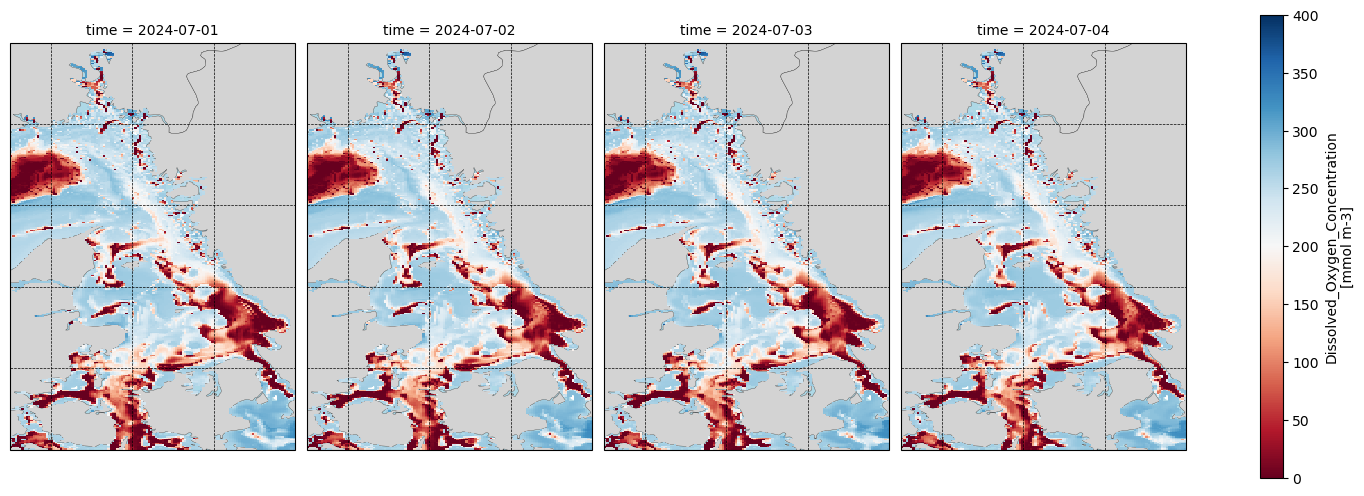

In [22]:
fig = ds.o2b.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    vmin=0, 
    vmax=400,
    cmap='RdBu',
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

In [23]:
## forward-fill all variables in time-series. 
## Let's also look at the first 4 days of data to visually verify that we're progressively filling in gaps
ds_fill = ds.ffill(dim='time', limit=7)
ds_fill
# remote Time dimension and average for each pixel across time series
ds_mean = ds_fill.mean(dim='time', skipna=True)

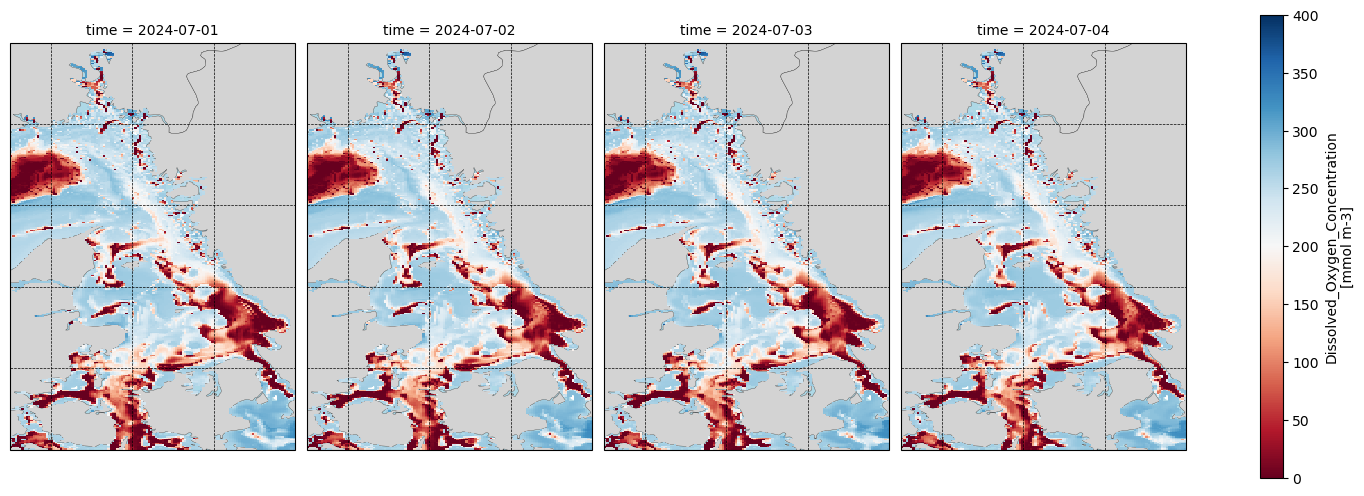

In [24]:
fig = ds_fill.o2b.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
#    col_wrap=3, 
    vmin=0, 
    vmax=400,
    cmap='RdBu',
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

In [25]:
# Hypoxia limit
value_ml_per_l = 2 
value_mmol_per_m3 = value_ml_per_l / 0.0224 #Hypoxia <2 ml/l (SMHI) ~89 mmol/m3
hypoxic_mask = xr.where(ds_mean.o2b < value_mmol_per_m3, 1, 0)
hypoxic_mask = hypoxic_mask.where(~np.isnan(ds_mean.o2b))

In [26]:
hypoxic_num =ds_mean['o2b'].to_numpy()

In [27]:
max_value =np.nanmax(hypoxic_num)
min_value =np.nanmin (hypoxic_num)
mean_value =np.nanmean(hypoxic_num)
median_value=np.nanmedian(hypoxic_num)
std_value =np. nanstd(hypoxic_num)
print(f"Mean: {mean_value}")
print(f"Max: {max_value}")
print(f"Min: {min_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standardization: {std_value}")

Mean: 188.1119384765625
Max: 363.1797180175781
Min: 8.050028249956847e-18
Mean: 188.1119384765625
Median: 229.48326110839844
Standardization: 88.7630844116211


<Axes: >

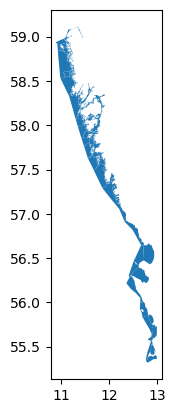

In [28]:
# read in kustvattenförekomster and clip to the study area

kvf = os.path.join('external_data', 'VM', 'vm.Kustvatten_Vattenforekomster_2016_1.shp')
kvf = gpd.read_file(kvf)
kvf = kvf.to_crs(4326)

c =  {'NW': [9.5, 60],
      'NE': [13, 60],
      'SW': [9.5, 55],
      'SE': [13, 55]}

bb = Polygon([c['NW'], c['NE'], c['SE'], c['SW']])

kvf_clipped = kvf.clip(bb)
kvf_clipped.plot()

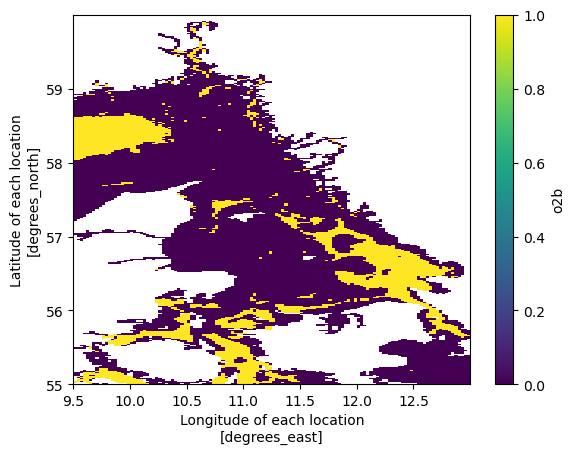

In [29]:
hypoxic_mask.plot()

In [30]:
# check out the geodataframe info
kvf_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 121 entries, 574 to 499
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    121 non-null    int64   
 1   UUID        121 non-null    object  
 2   MS_CD       121 non-null    object  
 3   EU_CD       121 non-null    object  
 4   VISS_MS_CD  121 non-null    object  
 5   NAMN        121 non-null    object  
 6   TYP_NFS06   121 non-null    int64   
 7   TYPOMRKUST  121 non-null    object  
 8   CATEGORY    121 non-null    object  
 9   WB          121 non-null    object  
 10  District    121 non-null    object  
 11  COMP_AUTH   121 non-null    object  
 12  Country     121 non-null    object  
 13  Version     121 non-null    object  
 14  URL_VISS    121 non-null    object  
 15  ObjVer      121 non-null    object  
 16  GVatten     121 non-null    object  
 17  UTL_EU_CD   4 non-null      object  
 18  UTL_MS_CD   4 non-null      object  
 19  SHA

In [31]:
# dissolve kvf by 'TYPOMRKUST'

kvf_dissolved = kvf_clipped.dissolve(by='TYPOMRKUST')
kvf_dissolved = kvf_dissolved.reset_index()

for row in kvf_dissolved.itertuples():
    print(f'Index {row.Index}: TYPOMRKUST <{row.TYPOMRKUST}>')

Index 0: TYPOMRKUST <1n>
Index 1: TYPOMRKUST <1s>
Index 2: TYPOMRKUST <2>
Index 3: TYPOMRKUST <25>
Index 4: TYPOMRKUST <3>
Index 5: TYPOMRKUST <4>
Index 6: TYPOMRKUST <5>
Index 7: TYPOMRKUST <6>
Index 8: TYPOMRKUST <7>


In [32]:
# iteratively create list of the o2b mean dataset clipped by the TYPOMRKUST areas

hypoxic_mask = hypoxic_mask.rio.write_crs(4326)
ds_mclipped=[]
for index, row in kvf_dissolved.iterrows():
    aoi = hypoxic_mask.rio.clip([row['geometry']], all_touched=True)
    ds_mclipped.append(aoi)

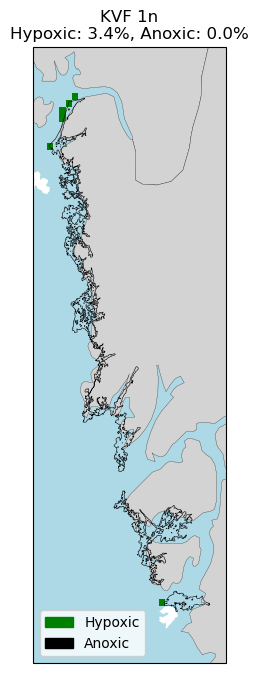

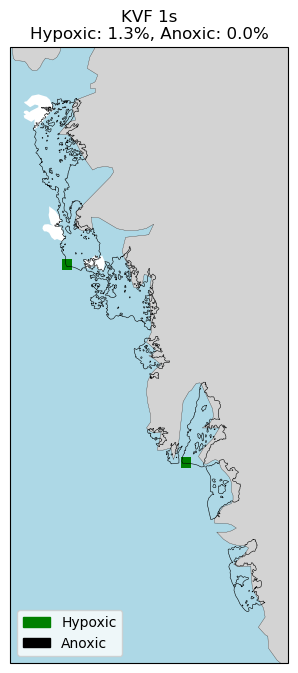

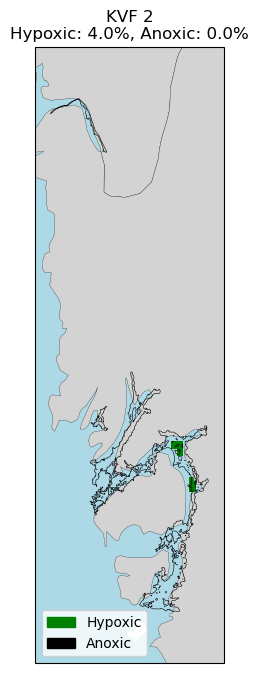

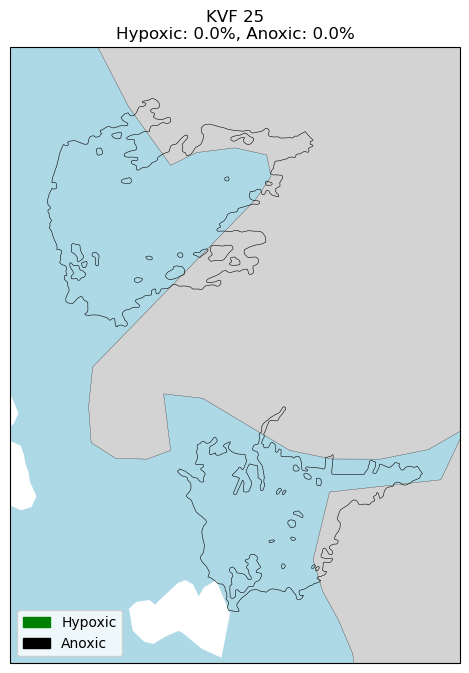

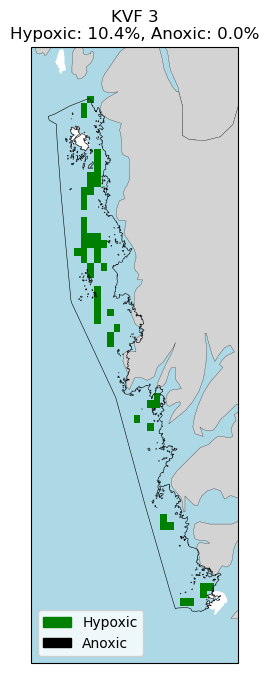

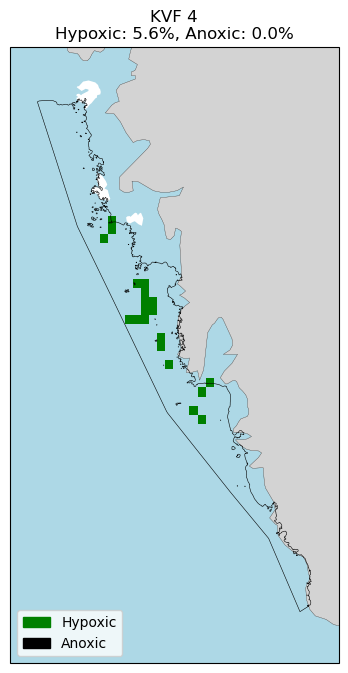

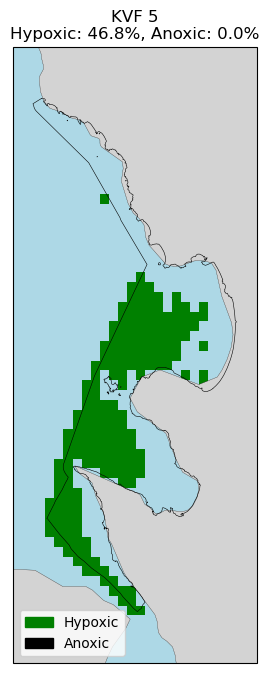

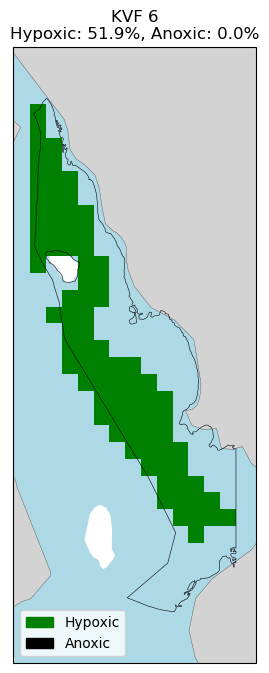

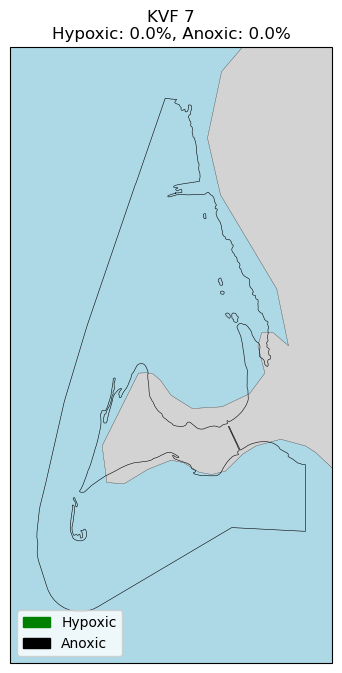

,Total area (km²),Hypoxic area (km²),Anoxic area (km²),Hypoxic %,Anoxic %
KVF,,,,,
1n,700,24,0,3.4,0.0
1s,604,8,0,1.3,0.0
2,504,20,0,4.0,0.0
25,104,0,0,0.0,0.0
3,2048,212,0,10.4,0.0
4,1436,80,0,5.6,0.0
5,1616,756,0,46.8,0.0
6,640,332,0,51.9,0.0
7,272,0,0,0.0,0.0


In [33]:
# Store results per coastal water area
results = []

# Define color map and labels
class_labels = {1: "Hypoxic", 2: "Anoxic"}
class_colors = ["green", "black"]  # 1 = Hypoxic, 2 = Anoxic
cmap = ListedColormap(class_colors)

# create dataArray that will hold the combined classification results for all processed water bodies
combined_array = None

# Loop through each coastal water body (KVF)
for ind in range(len(ds_mclipped)):
    mask = ds_mclipped[ind]  # Binary mask for this area (1 inside, NaN outside)
    o2_values = ds_mean.o2b.where(mask == 1)  # Get oxygen values only inside the KVF

    # Classify each pixel: 2 = Anoxic (≤ 0), 1 = Hypoxic (0–89), NaN otherwise
    classified = xr.full_like(o2_values, np.nan)
    classified = xr.where((o2_values > 0) & (o2_values <= 89), 1, classified)
    classified = xr.where(o2_values <= 0, 2, classified)

    # Mask values outside the polygon to avoid showing classification there
    classified = classified.where(mask == 1)

    class_da = xr.DataArray(
        classified,
        coords=o2_values.coords,
        dims=o2_values.dims
    )
    
    # Combine all classifications
    if combined_array is None:
        combined_array = class_da
    else:
        combined_array = combined_array.combine_first(class_da)

    # Calculate number of pixels in each class
    pixel_area_km2 = 4
    total_pixels = mask.count().values
    hypoxic_pixels = (classified == 1).sum().values
    anoxic_pixels = (classified == 2).sum().values

    total_area_km2 = total_pixels * pixel_area_km2
    hypoxic_area_km2 = hypoxic_pixels * pixel_area_km2
    anoxic_area_km2 = anoxic_pixels * pixel_area_km2

    hypoxic_percent = (hypoxic_area_km2 / total_area_km2) * 100
    anoxic_percent = (anoxic_area_km2 / total_area_km2) * 100

    # Get name of the KVF area
    try:
        KVF_name = kvf_dissolved.iloc[ind]['TYPOMRKUST']
    except:
        KVF_name = f"KVF {ind}"

    # Save statistics for table
    results.append({
        'KVF': KVF_name,
        'Total area (km²)': total_area_km2,
        'Hypoxic area (km²)': hypoxic_area_km2,
        'Anoxic area (km²)': anoxic_area_km2,
        'Hypoxic %': hypoxic_percent,
        'Anoxic %': anoxic_percent
    })

    # Create the map
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

    # Plot the classification map
    classified.plot(ax=ax, cmap=cmap, vmin=1, vmax=2, add_colorbar=False)

    # Plot KVF boundary
    kvf_dissolved.iloc[[ind]].boundary.plot(ax=ax, edgecolor="black", lw=0.4)

    # Zoom in to the polygon
    bounds = kvf_dissolved.iloc[ind].geometry.bounds
    minx, miny, maxx, maxy = bounds
    pad_x = (maxx - minx) * 0.1
    pad_y = (maxy - miny) * 0.1
    ax.set_xlim(minx - pad_x, maxx + pad_x)
    ax.set_ylim(miny - pad_y, maxy + pad_y)

    # Add background
    ax.add_feature(land, zorder=1)
    ax.add_feature(ocean, zorder=0)

    # Add title and labels
    ax.set_title(f"KVF {KVF_name}\nHypoxic: {hypoxic_percent:.1f}%, Anoxic: {anoxic_percent:.1f}%", fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Create legend
    legend_patches = [
        mpatches.Patch(color=class_colors[i - 1], label=label)
        for i, label in class_labels.items()
    ]
    ax.legend(handles=legend_patches, loc='lower left')

    plt.show()

# Show results as a table
df_results = pd.DataFrame(results)
df_results = df_results.set_index('KVF')
df_results[['Hypoxic %', 'Anoxic %']] = df_results[['Hypoxic %', 'Anoxic %']].round(1)
display(df_results)

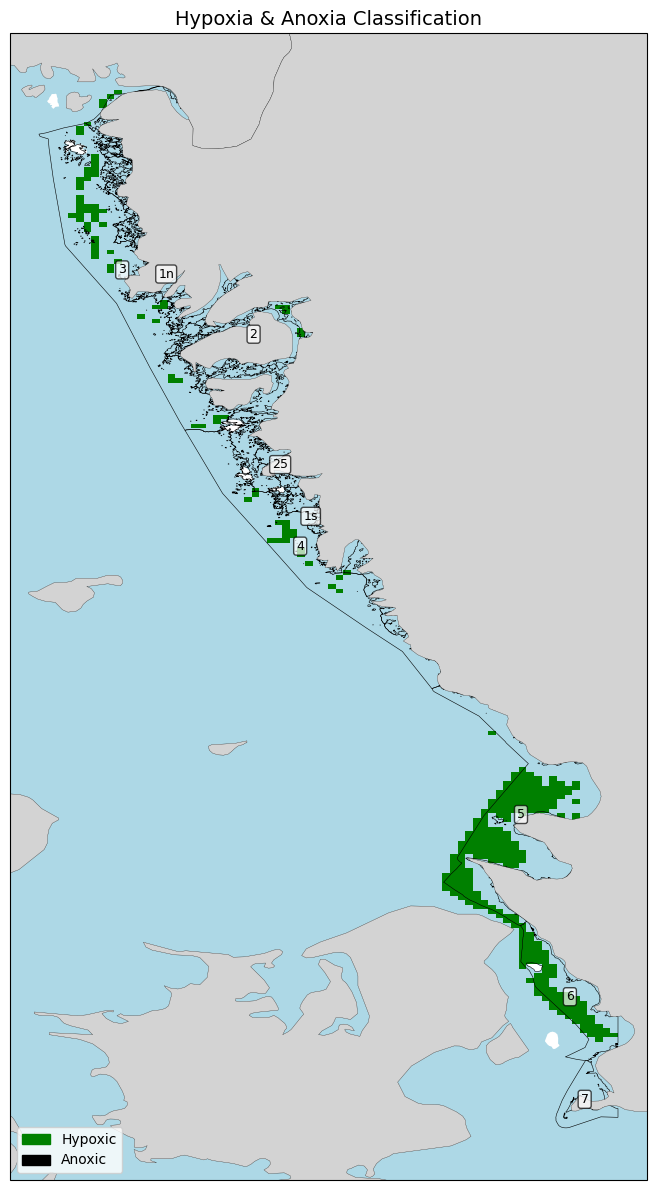

In [34]:
# Plot combined classification map
fig, ax = plt.subplots(1, 1, figsize=(15, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))

img = combined_array.plot(
    ax=ax,
    cmap=cmap,
    vmin=1,
    vmax=2,
    add_colorbar=False
)

# Create legend
legend_patches = [
     mpatches.Patch(color=class_colors[i - 1], label=label)
    for i, label in class_labels.items()
]
ax.legend(handles=legend_patches, loc='lower left')

# Plot boundaries
kvf_dissolved.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.4)

# Add labels on polygons
for idx, row in kvf_dissolved.iterrows():
    centroid = row.geometry.centroid
    label = str(row['TYPOMRKUST'])
    ax.text(
        centroid.x, centroid.y, label,
        fontsize=9, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.7)
    )

# Map extent and background
minx, miny, maxx, maxy = kvf_dissolved.total_bounds
pad_x = (maxx - minx) * 0.05
pad_y = (maxy - miny) * 0.05
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

ax.add_feature(land, zorder=1)
ax.add_feature(ocean, zorder=0)

# Title and layout
ax.set_title("Hypoxia & Anoxia Classification", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()